# IS-Academia Analysis
This is a data analysis of the IS-Academia data accessible by anyone, without authentication.

**Goal** : 
* Find out how much time do EPFL's students in Computer Science need to get their Bachelor. 
* Do a similar analysis for the Master's degree. 

---

## Collecting the Data

The challenge before analysing the data is to extract this data from the IS-Academia website. By looking at this [page](http://isa.epfl.ch/imoniteur_ISAP/%21gedpublicreports.htm?ww_i_reportmodel=133685247), we can extract information about the names and different values of the HTML `<input>` fields using *Beautiful Soup*. Then we will be able to generate a valid request to get the wanted data. 

### Analysing the requests using Postman

With the *Postman interceptor*, we can intercept requests when submitting the form we are interested in. 
A valid request URL looks like this : 

`http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_b_list=1&ww_i_reportmodel=133685247&ww_c_langue=&ww_i_reportModelXsl=133685270&zz_x_UNITE_ACAD=Informatique&ww_x_UNITE_ACAD=249847&zz_x_PERIODE_ACAD=2016-2017&ww_x_PERIODE_ACAD=355925344&zz_x_PERIODE_PEDAGO=Bachelor+semestre+1&ww_x_PERIODE_PEDAGO=249108&zz_x_HIVERETE=Semestre+d%27automne&ww_x_HIVERETE=2936286&dummy=ok`

You can see there are redundant information, for example : `zz_x_UNITE_ACAD=Informatique` and `ww_x_UNITE_ACAD=249847`. You can imagine that getting rid of one of them can still work. It's actually the case, you can get rid of all the `zz_x_*` parameters. With a closer analysis, you can see that the `ww_x_*` parameters correspond to the actual values in the HTML dropdowns.

So this is also a valid request :

`http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_b_list=1&ww_i_reportmodel=133685247&ww_c_langue=&ww_i_reportModelXsl=133685270&ww_x_UNITE_ACAD=249847&ww_x_PERIODE_ACAD=355925344&ww_x_PERIODE_PEDAGO=249108&ww_x_HIVERETE=2936286&dummy=ok`, much more simpler and shorter. 

Then the URL of the empty form page is given by 
`http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_i_reportmodel=133685247`
which is a little bit different from the IS-Academia link above, because the page is using frames and their HTML code are not included in the base page. 

From here, you can already guess the form paramters we are going to use, but the goal is to extract them and not hardcode them. At least now we have the request base and format.

IS-Academia generates a link, on which you can click to get the actual data. By inspecting the requests, we can see that the URL required to get the data contains all the parameters, and additionaly a parameter contained in the HTML source of the link, we will need to extract it to get the final data. 


### Getting the parameters using Beautiful Soup

The principle used to extract the parameters here is basically to use the text description provided in the HTML page, and then play with the DOM to extract the wanted values. Parameters are returned as a dictionnary. 

In [14]:
# Import Requests and Beautiful Soup
import requests as rq
from bs4 import BeautifulSoup

# Define the IS-Academia page
empty_form_url = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_i_reportmodel=133685247'

# Get the page by doing a HTTP request
empty_form = rq.get(empty_form_url)
if empty_form.status_code != rq.codes.ok:
    print("--> Error, I'm gonna crash... <--")

# Get the soup out of it
form_soup = BeautifulSoup(empty_form.text, 'html.parser')

def get_parameters(format, filters):
    """
    Returns a dictionnary containing the paramters
    
    format : 'xls' or 'html', selects the data format
    filters : dictionnary containing the values you want to select in the dropdowns
    """
    # Parameters dictionnary
    parameters = {}
    
    # First, get the checkbox parameters
    checkbox = form_soup.find(text = format).parent
    parameters[checkbox['name']] = checkbox['value']
    
    # Then get the dropdown parameters
    for f in filters:
        html_option = form_soup.find(text = f).parent
        param_name = html_option.parent['name']
        param_value = html_option['value']
        parameters[param_name] = param_value
        
    # Don't forget the hidden fields
    hidden = form_soup.find_all('input', type='hidden')
    
    # Ignore the zz_* fields, they are useless for what we want to do, 
    # also ignore ww_i_reportmodel, already contained in the base URL
    for field in hidden:
        if not (field['name'].startswith('z') or field['name'] == 'ww_i_reportmodel'):
            parameters[field['name']] = field['value']
            
    return parameters

### Getting the actual data

With the parameters, we are able to get the desired link to the data, a little bit of work on this page and we can "simulate" a click on this link by generating the good request. The data is then saved in a file, and the `get_data` function returns its path.

In [18]:
def get_data(parameters, format, filename):
    """
    Returns a file path with the data
    
    url : url of the file to download
    parameters : parameters of the request
    format : 'html' or 'xls
    """
    
    # Get the webpage with the data link
    link_page = rq.get(empty_form_url, parameters)
    if link_page.status_code != rq.codes.ok:
        print("--> Error, I'm gonna crash... <--")
    
    # Get the soup out of it
    link_soup = BeautifulSoup(link_page.text, 'html.parser')

    # The interesting link is the second of the page, and the parameters in this context : onlick:"...'name=value'".
    link_param = link_soup.find_all('a')[1]['onclick'].split('\'')[1].split('=')
    parameters[link_param[0]] = link_param[1]

    # The request needs a capitalized xls
    format = 'XLS' if format == 'xls' else format
    
    url = empty_form_url.replace('filter', format)
        
    # Thanks to http://stackoverflow.com/questions/16694907/how-to-download-large-file-in-python-with-requests-py
    r = rq.get(url, parameters)
    filename = filename + '.%s' % format
    
    with open(filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # Filter out keep-alive new chunks
                f.write(chunk) 
    return filename

We are ready to fetch the desired data and save it in a file : 

In [19]:
format = 'html'
filters = ['Informatique', 'Bachelor semestre 1', '2016-2017', 'Semestre d\'automne']
filename = 'test'

# Get the request parameters
params = get_parameters(format, filters)

# Save the actual data in a file
get_data(params, format, filename)

'test.html'

## Analysing the Data
Now that we have the code to fetch the data, we can start to analyze it. But first, we need to get all the tables we are interested in. 
I consider that the values appearing in the dropdown buttons are given, they are available to any user browsing the website. So we will use it to retrieve the data we want. 

In [20]:
# Import Pandas and NumPy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Question 1

In [21]:
# The section is always Informatique. 
section = 'Informatique'

# The academic period goes from 2007 to 2017
acad_period = ['2007-2008', '2008-2009', '2009-2010', '2010-2011', '2011-2012', '2012-2013', '2013-2014', 
          '2014-2015', '2015-2016', '2016-2017']

# The pedagogical period goes from Bachelor 1 to Bachelor 6
peda_period = [['Bachelor semestre 1', 'Bachelor semestre 3', 'Bachelor semestre 5'], 
               ['Bachelor semestre 2', 'Bachelor semestre 4', 'Bachelor semestre 6']]

# The semester type is either Semestre d'automne or Semestre de printemps
semester_type = ['Semestre d\'automne', 'Semestre de printemps']

# Choose the html format
format = 'html'

We fetch all the needed data and build dataframes out of it.

In [22]:
# Define a list of data frames
dfs = []

# Get all the possible files
for year in acad_period: 
    for season in semester_type:
        # Take only odd or even semesters, depending on the season
        semesters = peda_period[0] if season == semester_type[0] else peda_period[1]
        for sem in semesters: 
            filters = [section, year, season, sem]
            filename = 'data/' + '_'.join(filters)
            
            # Get the request parameters
            params = get_parameters(format, [section, year, season, sem])
            
            # Save the data
            get_data(params, format, filename)
            
            # Read the file
            df = pd.read_html(filename + '.' + format, skiprows=[0], header=0)[0]
            
            # Drop the NaN values, add the semester column
            df['Semester'] = sem
            df = df.dropna(axis=1)
            
            # Add to the list
            dfs.append(df)



Now, each request is in a dataframe, they are all contained in a list, it's time to process them.

In [19]:
dfs[0].head(5)

,Civilité,Nom Prénom,Statut,No Sciper,Semester
0,Monsieur,Arévalo Christian,Présent,169569,Bachelor semestre 1
1,Monsieur,Aubelle Flavien,Présent,174905,Bachelor semestre 1
2,Monsieur,Badoud Morgan,Présent,173922,Bachelor semestre 1
3,Monsieur,Baeriswyl Jonathan,Présent,179406,Bachelor semestre 1
4,Monsieur,Barroco Michael,Présent,179428,Bachelor semestre 1


We suppose in the next cell that a semester is 6 months. This is fair, we don't really want to know the number of months spent **on campus**, we are intersted in knowing the number of months spent **as registered at EPFL**.

The average time to get the Bachelor is : 40.758621 months for females and 42.635870 months for males.


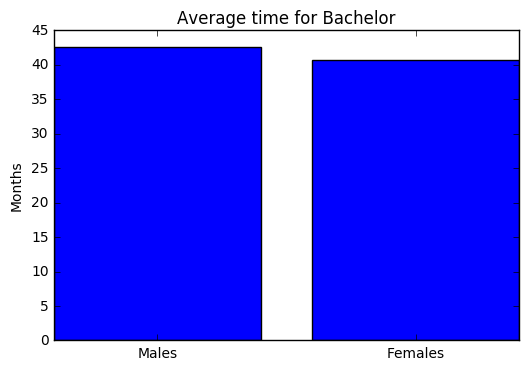

In [8]:
# Create one single big dataframe 
df = pd.concat(dfs)

# Drop the status
df = df.drop(['Statut'], axis=1)

# Drop people what does not contain Bachelor 1 and Bachelor 6
df = df.groupby('No Sciper').filter(lambda group: 'Bachelor semestre 1' in group['Semester'].unique()
                              and 'Bachelor semestre 6' in group['Semester'].unique())

# Count in each group, the number of entries in the semester column
df = df.groupby(['No Sciper', 'Nom Prénom', 'Civilité']).agg('count')

# Reset the index and group by sex
grouped = df.reset_index().groupby('Civilité')

# Get the values, these are the number of semester
female_values = grouped.get_group('Madame')['Semester']
male_values = grouped.get_group('Monsieur')['Semester']

# Suppose a semester is 6 months
female_values *= 6
male_values *= 6

print('The average time to get the Bachelor is : %f months for females and %f months for males.' 
      % (female_values.mean(), male_values.mean()))

# Plot 
means = {'Females' : female_values.mean(), 'Males' : male_values.mean()}
plt.bar(range(len(means)), means.values(), align='center')
plt.xticks(range(len(means)), means.keys())
plt.title('Average time for Bachelor')
plt.ylabel('Months')
plt.show()

Let's do a Two-Sample T-test on our values. We can apply this test because it tests if, given two sample means, we can say that the samples are significantly different or not.
Our Null Hypothesis $H_0$ here is that the two means are the same.

In [9]:
# Import the stats library
import scipy.stats as stats

# Perfom the T-test
stats.ttest_ind(female_values.values, male_values.values)

Ttest_indResult(statistic=-1.0643000334248713, pvalue=0.28784297465161934)

So in this case, the probability of getting our samples, given $H_0$ is true is $0.287$. Which is high, so we fail to reject the Null Hypothesis, and we say that **is not statistically significant**.

### Question 2

We will perfom a similar analysis on the master students. 
First we need to fetch all the data again, we are interested in the following tables : Master semestre 1, Master semestre 2, Master semestre 3 and Projet Master.

We decided to not take the fresh master students of the last two years into account, the reason is we don't know yet if these students are going to stay at EPFL or not. For example, a Master 1 student this current year would be counted as staying only one semester at EPFL, which is wrong, he would probably finish his master here, so we can't count him.

In [10]:
# We need to redefine the pedagocial periods 
peda_period = [['Master semestre 1', 'Master semestre 3', 'Projet Master automne'], 
               ['Master semestre 2', 'Projet Master printemps']]

# Define a list of dataframes
dfs = []

# Get all the possible files
for year in acad_period: 
    for season in semester_type:
        # Take only odd or even semesters, depending on the season
        semesters = peda_period[0] if season == semester_type[0] else peda_period[1]
        for sem in semesters:
            # Skip the fresh master students, see above to know why
            if sem == 'Master semestre 1' and (year == '2016-2017' or year == '2015-2016'):
                continue
                
            filters = [section, year, season, sem]
            
            filename = 'data/' + '_'.join(filters)
            
            # Get the request parameters
            params = get_parameters(format, [section, year, season, sem])
            
            # Save the data
            get_data(params, format, filename)
            
            # Read the file
            try:
                df = pd.read_html(filename + '.' + format, skiprows=[0], header=0)[0]
            except IndexError:
                print('File %s empty, skipping it...' % filename)
            
            # Drop the NaN values, add the semester column
            df['Semester'] = sem
            df = df.dropna(axis=1, how='all')
            
            # Add to the list
            dfs.append(df)

File data/Informatique_2014-2015_Semestre de printemps_Projet Master printemps empty, skipping it...
File data/Informatique_2015-2016_Semestre de printemps_Projet Master printemps empty, skipping it...
File data/Informatique_2016-2017_Semestre de printemps_Projet Master printemps empty, skipping it...


Now we can start to process the data :

In [11]:
# Create one big data frame
df = pd.concat(dfs)

# Let's drop the exchange related columns, that we dont use in this context
df = df.drop(['Ecole Echange', 'Type Echange', 'Statut'], axis=1)

# Group by students, this gives us the number of Semesters for each student
df_count = df.groupby(['No Sciper', 'Nom Prénom', 'Civilité']).agg('count').drop(['Mineur', 'Spécialisation'], axis=1)
df_count.head(5)

,,,Semester
No Sciper,Nom Prénom,Civilité,
128911,Gulati Asheesh,Monsieur,2
129093,Zhou Maoan,Monsieur,2
129326,Ni Zhong Zhong,Monsieur,2
138088,Droz-dit-Busset Arnault,Monsieur,1
145546,Clivaz Jean-Philippe,Monsieur,1


In [12]:
# Compute the average stay at EPFL
semester_count = df_count['Semester']
average_stay = semester_count.mean()
print('The average stay at EPFL for a master student is %f semesters.' % average_stay)

The average stay at EPFL for a master student is 3.413551 semesters.


Now we want to compute this average stay for each specialisation.

In [13]:
# We will reuse our favorite dataframe 
df.head(5)

,Civilité,Mineur,No Sciper,Nom Prénom,Semester,Spécialisation
0,Monsieur,NaN,153066,Aeberhard François-Xavier,Master semestre 1,NaN
1,Madame,NaN,180027,Agarwal Megha,Master semestre 1,NaN
2,Monsieur,NaN,152232,Anagnostaras David,Master semestre 1,NaN
3,Monsieur,NaN,177395,Auroux Damien,Master semestre 1,NaN
4,Monsieur,NaN,161970,Awalebo Joseph,Master semestre 1,NaN


In [14]:
# Filter the students who didn't take any specialisation during their cursus
df_spe = df.groupby(['No Sciper', 'Nom Prénom', 'Civilité']).filter(lambda x : not x['Spécialisation'].isnull().all())

# Aggregate the spé by taking the actual spécialisation and not a NaN cell, and count the semesters
agg = {'Spécialisation' : (lambda x : x.value_counts().index[0]), 'Semester' : 'count'}
df_count = df_spe.groupby(['Nom Prénom', 'No Sciper', 'Civilité']).agg(agg)
df_count.head(5)

,,,Semester,Spécialisation
Nom Prénom,No Sciper,Civilité,,
Abelenda Diego,170646,Monsieur,4,"Signals, Images and Interfaces"
Aeberhard François-Xavier,153066,Monsieur,6,Internet computing
Aeby Prisca,225654,Madame,3,Internet Information Systems
Andreina Sébastien Laurent,215623,Monsieur,3,Information Security - SP
Antognini Marco,194182,Monsieur,9,Foundations of Software


Internet Information Systems : 3.000000 semesters in average. 

Internet computing : 3.851852 semesters in average. 

Software Systems : 3.764706 semesters in average. 

Data Analytics : 2.600000 semesters in average. 

Information Security - SP : 4.142857 semesters in average. 

Signals, Images and Interfaces : 3.805556 semesters in average. 

Computer Engineering - SP : 4.095238 semesters in average. 

Biocomputing : 2.250000 semesters in average. 

Service science : 3.666667 semesters in average. 

Foundations of Software : 4.212121 semesters in average. 

Computer Science Theory : 3.000000 semesters in average. 



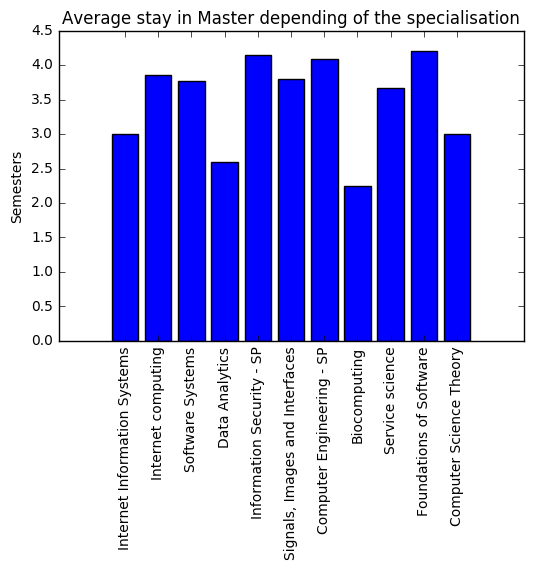

In [17]:
# Group by specialisation
spe_group = df_count.reset_index().groupby('Spécialisation')

spe_count

# For each specialisation, extract the semester count
spe_count = {}
for name, group in spe_group:
    spe_count[name] = group['Semester'].values

# Map each sample to its mean
means = {k: v.mean() for k, v in spe_count.items()}

# Print the means
for key in means:
    print('%s : %f semesters in average. \n' % (key, means[key]))
    
# Plot 
plt.bar(range(len(means)), means.values(), align='center')
plt.xticks(range(len(means)), means.keys(), rotation=90)
plt.title('Average stay in Master depending of the specialisation')
plt.ylabel('Semesters')
plt.show()

Let's compute some statistics now. We will use the same test than for the Bachelor, for the same reason.

In [86]:
# Perfom the T-test
for key in spe_count:
    test = stats.ttest_ind(spe_count[key], semester_count)
    print('Test for the spécialisation %s \n       --> ' % key, test, '\n')

Test for the spécialisation Internet Information Systems 
       -->  Ttest_indResult(statistic=nan, pvalue=nan) 

Test for the spécialisation Software Systems 
       -->  Ttest_indResult(statistic=0.95313733772618514, pvalue=0.34078492020617712) 

Test for the spécialisation Data Analytics 
       -->  Ttest_indResult(statistic=-1.2054913612364975, pvalue=0.22834563356620999) 

Test for the spécialisation Information Security - SP 
       -->  Ttest_indResult(statistic=1.2715960201633913, pvalue=0.20386006818285737) 

Test for the spécialisation Signals, Images and Interfaces 
       -->  Ttest_indResult(statistic=1.5096157240684995, pvalue=0.13149642620391269) 

Test for the spécialisation Computer Engineering - SP 
       -->  Ttest_indResult(statistic=2.0396253695405653, pvalue=0.041687578897214882) 

Test for the spécialisation Biocomputing 
       -->  Ttest_indResult(statistic=-2.6499328488218254, pvalue=0.0081975848133832765) 

Test for the spécialisation Service science 
    

/usr/local/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


First we can see that the test fails for two specialisation, we don't have enough samples.

For the others, the **p value** is under the 5% signication level for the following spécialisation : 
* Foundations of Software
* Internet Computing
* BioComputing
* Computer Engineering

Which means that for these specialisations, we can reject the null hypothesis $H_0$, and say that the original mean is significantly different from these means. 